In [17]:
def determine(lst):
    return (all(x == 0.0 for x in lst))

def check_zeros(data):
    new_data = []
    for i in data:
        if not determine(i[1]):
            if new_data == None:
                new_data = i
            else:
                new_data.append(i)
    return new_data


def merge_amino_nuc(amino, nuc):
    final_df = nuc
    return final_df.join(amino.iloc[:, :2].set_index('pid'), on='pid', how='inner')


#get all the data from a specific order
def get_data_order(data, order_name):
    new_data = []

    if (order_name == 'coleoptera'):
        index_one = 0
    elif (order_name == 'diptera'):
        index_one = 1
    elif (order_name == 'hymenoptera'):
        index_one = 2
    elif (order_name == 'lepidoptera'):
        index_one = 3
    
    for i in range(len(data)):
        code_order = data[i][2][index_one]
        if(code_order == 1):
            data[i][2] = [1,0]
        else:
            data[i][2] = [0,1]
        new_data.append(data[i])
            
    return new_data

def read_pids_fasta(file_fasta):
    pids = []
    for record in SeqIO.parse(file_fasta, "fasta"):
        record_id = record.id
        pids.append(record_id.split("|")[0])        
    return pids

def save_object(obj, filename):
    with open(filename, 'wb') as output:  
        pickle.dump(obj, output, protocol=2)
        
def split_new(data,training_percent):
    training_percent = float(training_percent)
    for i in range(len(data)):
        if i < int(len(data)*training_percent):
            data[i].append(['train'])
        else:
            data[i].append(['test'])
    return data
    
def split(feature_file,training_percent):

    training_percent = float(training_percent)
    
    with open("../feature_data/" + feature_file, 'rb') as file:
        data = pickle.load(file)
        for i in range(len(data)):
            if i < int(len(data)*training_percent):
                data[i].append(['train'])
            else:
                data[i].append(['test'])
        return data
        #save_object(data, "train_and_test/tt-" + str(training_percent) + "-" + feature_file)

def build_DNN(train_x,train_y):
    tf.reset_default_graph()
    # Build neural network - input data shape, number of words in vocabulary (size of first array element). 
    net = tflearn.input_data(shape=[None, len(train_x[0])])
    # Two fully connected layers with 8 hidden units/neurons - optimal for this task
    net = tflearn.fully_connected(net, 4)
    net = tflearn.fully_connected(net, 4,activation='softmax')
    # number of intents, columns in the matrix train_y
    #net = tflearn.fully_connected(net, len(train_y[0]), activation='softmax')
    # regression to find best parameters, during training
    net = tflearn.regression(net)

    # Define Deep Neural Network model and setup tensorboard
    model = tflearn.DNN(net, tensorboard_dir='tflearn_sequence_logs')
    return modell

def build_DNN_Arch1(aa_length, nu_length, y_length):
    tf.reset_default_graph()
    # Build neural network - input data shape, number of words in vocabulary (size of first array element). 
    net_aa = tflearn.input_data(shape=[None, aa_length], name="InputData0")
    net_nu = tflearn.input_data(shape=[None, nu_length], name="InputData1")
    # Two fully connected layers with 8 hidden units/neurons
    net_aa = tflearn.fully_connected(net_aa, 4)
    net_nu = tflearn.fully_connected(net_nu, 4)
    # number of intents, columns in the matrix train_y
    net = tflearn.merge_outputs([net_aa, net_nu])
    net = tflearn.fully_connected(net, 4)
    net = tflearn.fully_connected(net, y_length, activation='sigmoid')
    # regression to find best parameters, during training
    net = tflearn.regression(net, optimizer='adam')

    # Define Deep Neural Network model and setup tensorboard
    model = tflearn.DNN(net, tensorboard_dir='tflearn_arch1_logs', tensorboard_verbose=3)
    return model

def build_DNN_Arch2(aa_length, nu_length, y_length):
    tf.reset_default_graph()
    # Build neural network - input data shape, number of words in vocabulary (size of first array element). 
    net_aa = tflearn.input_data(shape=[None, aa_length], name="InputData0")
    net_nu = tflearn.input_data(shape=[None, nu_length], name="InputData1")
    # Two fully connected layers with 8 hidden units/neurons
#     net_aa = tflearn.fully_connected(net_aa, 4)
    net_nu = tflearn.fully_connected(net_nu, 4)
    # number of intents, columns in the matrix train_y
    net = tflearn.merge_outputs([net_aa, net_nu])
    net = tflearn.fully_connected(net, 4)
    net = tflearn.fully_connected(net, y_length, activation='sigmoid')
    # regression to find best parameters, during training
    net = tflearn.regression(net, optimizer='adam')

    # Define Deep Neural Network model and setup tensorboard
    model = tflearn.DNN(net, tensorboard_dir='tflearn_arch2_logs', tensorboard_verbose=3)
    return model

def train_DNN(model, train_x,train_y,classes):
    # Start training (apply gradient descent algorithm)
    # n_epoch - number of epoch to run
    # Batch size defines number of samples that going to be propagated through the network.
    model.fit(train_x, train_y, n_epoch=5, batch_size=5, show_metric=True)
    model.save('model/'+classes[0]+'_'+classes[1]+'.tflearn')

def train_DNN_arch12(model, train_aa, train_nu, train_y,classe,arch,grp):
    # Start training (apply gradient descent algorithm)
    # n_epoch - number of epoch to run
    # Batch size defines number of samples that going to be propagated through the network.
    model.fit({"InputData0":train_aa,"InputData1":train_nu}, train_y, n_epoch=5, batch_size=5, show_metric=True)
    model_name = 'model/'+classe+'_block_'+grp+'_'+arch+'.tflearn'
    model.save(model_name)
    return model_name
    
def predict_old(frequency,model,classes):

    ERROR_THRESHOLD = 0.5
    
    # generate probabilities from the model
    results = model.predict(frequency)[0]

    # filter out predictions below a threshold, and provide intent index
    results = [[i,r] for i,r in enumerate(results) if r>ERROR_THRESHOLD]

    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append(classes[r[0]])
    
    return return_list

def predict(model, test_aa, test_nu,classes):
    results = model.predict({"InputData0":[test_aa],"InputData1":[test_nu]})[0]

    new_results = results
    if results[0] > results[1]:
        #new_results[0] = results[0]
        #new_results[1] = results[1]
        class_result = 0
    else:
        #new_results[0] = results[1]
        #new_results[1] = results[0]
        class_result = 1

    #return_list = []
    #return_list.append((classes[class_result], str(new_results[0])))
    return classes[class_result], float(results[0]), float(results[1])

def predict_with_threshold(model, test_aa, test_nu,classes):
    
    THRESHOLD = 0.5
        
    results = model.predict({"InputData0":[test_aa],"InputData1":[test_nu]})[0]
    
    if(results[0] >= THRESHOLD):
        class_index = 0 #The first class is the positive class
    else:
        class_index = 1 

    return classes[class_index], results[0]

def fix_format(string):
    return re.sub('[\[\]\']','',string)

def plot_roc(y_test,y_score):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test = array(y_test)
    y_score = array(y_score)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    roc_auc = auc(fpr, tpr)

    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.5f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

def metrics_DNN(predict_y,id_test,test_y,classes,scores):
    
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    id_misclassified = []
    pred_misclassified = []
    y_misclassified = []
    all_pred = []
    all_y = []
    
    #class[0] is the positive class, test_y == 1 is the positive class
    for i in range(len(predict_y)):
        if (predict_y[i] == classes[0] and test_y[i] == 1):
            true_positive += 1
            all_pred.append(classes[0])
            all_y.append(classes[0])
        elif (predict_y[i] == classes[1] and test_y[i] == 0):
            true_negative += 1
            all_pred.append(classes[1])
            all_y.append(classes[1])
        elif(predict_y[i] == classes[1] and test_y[i] == 1):
            false_negative += 1
            pred_misclassified.append(predict_y[i])
            id_misclassified.append(id_test[i])
            y_misclassified.append(classes[0])
            all_pred.append(classes[0])
            all_y.append(classes[0])
        elif(predict_y[i] == classes[0] and test_y[i] == 0):
            false_positive += 1
            pred_misclassified.append(predict_y[i])
            id_misclassified.append(id_test[i])
            y_misclassified.append(classes[1])
            all_pred.append(classes[1])
            all_y.append(classes[1])
        
    df_all = pd.DataFrame({'id': id_test, 'predicted': all_pred, 'real_class': all_y})
    df_misclassified = pd.DataFrame({'id': id_misclassified,'predicted': pred_misclassified,'real_class': y_misclassified})
            
    precision_classe0 = float(true_positive)/(true_positive + false_positive)
    sensitivity = float(true_positive)/(true_positive + false_negative) #recall for class0
    F1_score_class0 = 2*(float(precision_classe0*sensitivity)/(precision_classe0 + sensitivity))
    
    precision_classe1 = float(true_negative)/(true_negative + false_negative)
    specificity = float(true_negative)/(false_positive + true_negative)#recall for class1
    F1_score_class1 = 2*(float(precision_classe1*specificity)/(precision_classe1 + specificity))
    
    accuracy = float(true_positive + true_negative)/len(predict_y)
    
    print("Class " + classes[0] +":")
    print("Precision: " + str(precision_classe0))
    print("Sensitivity: " + str(sensitivity))
    print("F1 score: " + str(F1_score_class0))
    
    print("")
    
    print("Class " + classes[1] +":")
    print("Precision: " + str(precision_classe1))
    print("Specificity: " + str(specificity))
    print("F1 score: " + str(F1_score_class1))
    
    print("")
    
    print("Accuracy:")
    print(accuracy)

    plot_roc(test_y,scores)
    
    return df_all

def merge_dataframe(df1, df2, column_names):
    final_df = df1
    return final_df.join(df2[column_names].set_index('pid'), on='pid', how='inner')

In [2]:
def get_train_test_data(nu_list,aa_list):
    index_pid = 0
    index_x = 1
    index_y = 2
    index_label = 3
    train_aa_x = [] 
    train_nu_x = []
    data_y_train = [] 
    test_aa_x = []
    test_nu_x = []
    data_y_test = []
    pids_test = []
    
    for i in range(len(nu_list)):
        if ((nu_list[i][index_label][0]) == 'train'):
            train_nu_x.append(nu_list[i][index_x])
            data_y_train.append(nu_list[i][index_y])
        else:
            test_nu_x.append(nu_list[i][index_x])
            data_y_test.append(nu_list[i][index_y])
            pids_test.append(nu_list[i][index_pid])
            
    for i in range(len(aa_list)):
        if ((aa_list[i][index_label][0]) == 'train'):
            train_aa_x.append(aa_list[i][index_x])
        else:
            test_aa_x.append(aa_list[i][index_x])
            
    return train_aa_x, train_nu_x, data_y_train, test_aa_x, test_nu_x, data_y_test, pids_test

In [3]:
def Average(lst): 
    return sum(lst) / len(lst) 

In [4]:
def combination_1(scores_pos, scores_neg, classes):
    avg_pos = Average(scores_pos)
    avg_neg = Average(scores_neg)
    
    if (avg_pos >= avg_neg):
        return classes[0], avg_pos
    else:
        return classes[1], avg_pos #always return the positive probability
    
def combination_2(predicted_classes, scores_pos, scores_neg, classes):
    pos_cls_count = predicted_classes.count(classes[0])
    neg_cls_count = predicted_classes.count(classes[1])
    if pos_cls_count < neg_cls_count:
        indices = [i for i, x in enumerate(predicted_classes) if x == classes[1]]
        avg_pos = [scores_pos[i] for i in indices]
        avg_pos = Average(avg_pos)
        return classes[1], avg_pos
    elif neg_cls_count < pos_cls_count:
        indices = [i for i, x in enumerate(predicted_classes) if x == classes[0]]
        avg_pos = [scores_pos[i] for i in indices]
        avg_pos = Average(avg_pos)
        return classes[0], avg_pos
    else:
        return combination_1(scores_pos, scores_neg, classes)

In [5]:
import numpy as np
import tflearn
import tensorflow as tf
from random import shuffle
import pickle
from collections import Counter
from sklearn.model_selection import KFold, cross_val_score
import argparse
import pandas as pd
import re
from sklearn.metrics import roc_curve, auc
from numpy import array
import matplotlib.pyplot as plt

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
classes = ['diptera', 'not_diptera']
tt_dict = {}
for i in range(0,6):
    i = str(i)
    nuc_filename = "ensemble_data/%snucblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl" % (i)
    amino_filename = "ensemble_data/%saminoblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl" % (i)
    nuc_x_name = 'ndata_x%s' % (i)
    amino_x_name = 'adata_x%s' % (i)
    data_y_name = 'data_y%s' % (i)
    tt_dict[i] = {}
    with open(nuc_filename, 'rb') as file:
        nuc_data = pickle.load(file)
        shuffle(nuc_data)
        nuc_data = check_zeros(nuc_data)
        nuc_data = get_data_order(nuc_data, classes[0])
        nuc_data = pd.DataFrame(data = nuc_data, columns=['pid', nuc_x_name, data_y_name])
    with open(amino_filename, 'rb') as file:
        amino_data = pickle.load(file)
        shuffle(amino_data)
        amino_data = check_zeros(amino_data)
        amino_data = get_data_order(amino_data, classes[0])
        amino_data = pd.DataFrame(data = amino_data, columns=['pid', amino_x_name, data_y_name])
        
    final_df = merge_amino_nuc(amino_data, nuc_data)
    nu_list = final_df[['pid',nuc_x_name,data_y_name]].values.tolist()
    aa_list = final_df[['pid',amino_x_name,data_y_name]].values.tolist()
    nu_list = split_new(nu_list,0.1)
    aa_list = split_new(aa_list,0.1)
    
    train_aa_x, train_nu_x, train_y, test_aa_x, test_nu_x, test_y, test_pid = get_train_test_data(nu_list,aa_list)
    tt_dict[i]['train_aa_x'] = train_aa_x
    tt_dict[i]['train_nu_x'] = train_nu_x
    tt_dict[i]['test_aa_x'] = test_aa_x
    tt_dict[i]['test_nu_x'] = test_nu_x
    tt_dict[i]['train_y'] = train_y
    tt_dict[i]['test_y'] = test_y
    tt_dict[i]['test_pid'] = test_pid

# Train

In [7]:
def make_df_predictions(model,test_aa_x,test_nu_x,test_y, pids,classes,grp):
    class_list =[]
    scores_pos = []
    scores_neg = []
    for i in range(len(test_aa_x)):
        cls, scr_pos,scr_neg = predict(model, test_aa_x[i], test_nu_x[i],classes)
        class_list.append(cls)
        scores_pos.append(scr_pos)
        scores_neg.append(scr_neg)
    score_pos_name = 'score_pos_%s' % (grp)
    score_neg_name = 'score_neg_%s' % (grp)
    predict_class_name = 'predict_class_%s' % (grp)
    test_name = 'test_%s' % (grp)
    df = pd.DataFrame({'pid': pids, score_pos_name: scores_pos, score_neg_name: scores_neg, predict_class_name: class_list, test_name: test_y})
    return df

In [8]:
%%time
count = 0
df_all = None
for i in range(0,6):
    i = str(i)
    model = build_DNN_Arch1(len(tt_dict[i]['train_aa_x'][0]), len(tt_dict[i]['train_nu_x'][0]), len(tt_dict[i]['train_y'][0]))
    model_name = train_DNN_arch12(model, tt_dict[i]['train_aa_x'], tt_dict[i]['train_nu_x'], tt_dict[i]['train_y'], classes[0],'1',i)
    model.load(model_name) 
    each_df = make_df_predictions(model,tt_dict[i]['test_aa_x'],tt_dict[i]['test_nu_x'], tt_dict[i]['test_y'], tt_dict[i]['test_pid'],classes,i)
    if count == 0:
        df_all = each_df
    else:
        df_all = pd.merge(df_all,each_df,how='outer',on='pid')
    count += 1

Training Step: 2999  | total loss: 0.35721 | time: 1.962s
| Adam | epoch: 005 | loss: 0.35721 - acc: 0.8723 -- iter: 2995/2998
Training Step: 3000  | total loss: 0.34972 | time: 1.965s
| Adam | epoch: 005 | loss: 0.34972 - acc: 0.8851 -- iter: 2998/2998
--
INFO:tensorflow:/Users/jennyyu/Documents/sequence_classification/ensemble_classifiers/model/diptera_block_5_1.tflearn is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Restoring parameters from /Users/jennyyu/Documents/sequence_classification/ensemble_classifiers/model/diptera_block_5_1.tflearn
CPU times: user 20min 44s, sys: 3min 9s, total: 23min 53s
Wall time: 18min 17s


In [9]:
df_all.head()

pid  score_pos_0  score_neg_0 predict_class_0  test_0  \
0    LNAUU851-15     0.000142     1.000000     not_diptera  [0, 1]   
1    KMPYD024-18     0.992467     0.000015         diptera  [1, 0]   
2     MNAK858-14     0.000272     0.999998     not_diptera  [0, 1]   
3  GBMIN57411-17     0.674208     0.034239         diptera  [1, 0]   
4   ASARD6120-12     0.004033     0.999756     not_diptera  [0, 1]   

   score_pos_1  score_neg_1 predict_class_1 test_1  score_pos_2  ...    \
0          NaN          NaN             NaN    NaN     0.018749  ...     
1          NaN          NaN             NaN    NaN          NaN  ...     
2          NaN          NaN             NaN    NaN          NaN  ...     
3          NaN          NaN             NaN    NaN     0.960622  ...     
4          NaN          NaN             NaN    NaN     0.012581  ...     

   predict_class_3  test_3 score_pos_4  score_neg_4  predict_class_4  test_4  \
0      not_diptera  [0, 1]         NaN          NaN              NaN     NaN   
1              NaN     NaN    0.544914     0.112637          diptera  [1, 0]   
2      not_diptera  [0, 1]         NaN          NaN              NaN     NaN   
3          diptera  [1, 0]    0.925362     0.004363          diptera  [1, 0]   
4              NaN     NaN         NaN          NaN              NaN     NaN   

  score_pos_5  score_neg_5  predict_class_5 test_5  
0         NaN          NaN              NaN    NaN  
1         NaN          NaN              NaN    NaN  
2         NaN          NaN              NaN    NaN  
3         NaN          NaN              NaN    NaN  
4         NaN          NaN              NaN    NaN  

[5 rows x 25 columns]

In [10]:
#Combine everything
score_pos_title = []
score_neg_title = []
predict_class_title = []
test_title = []
for i in range(0,6):
    i = str(i)
    score_pos_name = 'score_pos_%s' % (i)
    score_neg_name = 'score_neg_%s' % (i)
    predict_class_name = 'predict_class_%s' % (i)
    test_name = 'test_%s' % (i)
    score_pos_title.append(score_pos_name)
    score_neg_title.append(score_neg_name)
    predict_class_title.append(predict_class_name)
    test_title.append(test_name)
    
class_ens = []
score_ens = []
real_cls = []

#get scores of the dataframe
df_score_pos = df_all[score_pos_title]
df_score_neg = df_all[score_neg_title]
df_predict_cls = df_all[predict_class_title]
df_real_cls = df_all[test_title]

for index, row in df_all.iterrows():
    l_scores_pos = df_score_pos.iloc[index]
    l_scores_neg = df_score_neg.iloc[index]
    l_predict_cls = df_predict_cls.iloc[index]
    l_real_cls = df_real_cls.iloc[index]
    clean_pos = [x for x in l_scores_pos if str(x) != 'nan']
    clean_neg = [x for x in l_scores_neg if str(x) != 'nan']
    clean_predict_cls = [x for x in l_predict_cls if str(x) != 'nan']
    clean_real_cls = [x for x in l_real_cls if str(x) != 'nan']
   
    cls,scr = combination_2(clean_predict_cls, clean_pos, clean_neg, classes)
    class_ens.append(cls)
    score_ens.append(scr)
    real_cls.append(clean_real_cls[0])


In [11]:
#create final dataframe with results and save
final_result = df_all[['pid']]
final_result = final_result.assign(order=class_ens)
final_result = final_result.assign(score=score_ens)
final_result = final_result.assign(real_class = real_cls)


Class diptera:
Precision: 0.9664199072422405
Sensitivity: 0.9531328342848095
F1 score: 0.9597303844501623

Class not_diptera:
Precision: 0.9777300351939009
Specificity: 0.9841595738862267
F1 score: 0.9809342690421426

Accuracy:
0.9741210020320691


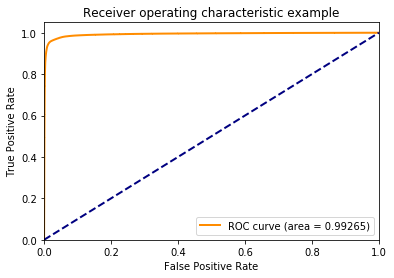

In [18]:
#Metrics
tes_first_neuron = [item[0] for item in final_result['real_class']] #get the first bit

#function that calculate all metrics
df_all = metrics_DNN(final_result['order'], final_result['pid'], tes_first_neuron,classes,final_result['score'])


In [19]:
df_all.to_csv('output_data/'+'all_data_'+classes[0]+'.tsv',index=False,sep='\t')